### Fidap Demo  
  
In this demo notebook, we want to answer the following questions:  
1) Which counties have the lowest overall Covid-19 mortality rates?  
2) Which states have the lowest overall Covid-19 infection rates?

In [127]:
from fidap import fidap_client
from config import api_key
import pandas as pd
import altair as alt
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt

# instantiate api connection
fidap = fidap_client(api_key=api_key)

We can start by simply gathering information from all counties based on the NYT dataset and the date today. We have to subtract one day from today because of the time lag and any potential time differences in gathering data. 

In [128]:
nyt_covid19 = fidap.sql("""
SELECT *
FROM bigquery-public-data.covid19_nyt.us_counties
WHERE date = EXTRACT(DATE FROM TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 1 DAY))
ORDER BY confirmed_cases DESC
LIMIT 20;
""")

We can also select population numbers from the ACS survey. 

In [129]:
acs_population = fidap.sql("""
SELECT total_pop, geo_id
FROM bigquery-public-data.census_bureau_acs.county_2018_5yr
LIMIT 20;
""")

**County-Level**

Putting these two together, we can get the following query to get per-capita caseloads and number of deaths for every 10,000 residents in each county in the United States.

In [132]:
### SQL query to get infection rates 
infection_rate_query = fidap.sql("""
WITH covid_cases AS (
SELECT *
FROM bigquery-public-data.covid19_nyt.us_counties
WHERE date = EXTRACT(DATE FROM TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 1 DAY))) 

SELECT acs.total_pop, c.county, c.state_name, c.confirmed_cases, c.deaths, (ROUND(10000*c.confirmed_cases/acs.total_pop, 2))  AS per_capita_county_infection_rate_10k, (ROUND(10000*c.deaths/acs.total_pop,2))  AS per_capita_county_death_rate_10k
FROM covid_cases AS c
INNER JOIN bigquery-public-data.census_bureau_acs.county_2018_5yr AS acs 
ON acs.geo_id = c.county_fips_code
ORDER BY per_capita_county_infection_rate_10k;
""")

In [133]:
infection_rate_query.head(n=10)

,total_pop,county,state_name,confirmed_cases,deaths,per_capita_county_infection_rate_10k,per_capita_county_death_rate_10k
0,71377,Kauai,Hawaii,400,2.0,56.04,0.28
1,2518,Haines Borough,Alaska,28,0.0,111.20,0.00
2,16473,San Juan,Washington,186,0.0,112.91,0.00
3,75,Kalawao,Hawaii,1,0.0,133.33,0.00
4,30856,Jefferson,Washington,455,4.0,147.46,1.30
5,197658,Hawaii,Hawaii,3312,55.0,167.56,2.78
6,102,Loving,Texas,2,0.0,196.08,0.00
7,74487,Clallam,Washington,1467,13.0,196.95,1.75
8,1061,Skagway Municipality,Alaska,21,0.0,197.93,0.00
9,16783,Guanica,Puerto Rico,342,NaN,203.78,NaN


**State-Level**

In [135]:
## get state numbers
state_infection = infection_rate_query.copy().groupby('state_name').agg(
    total_pop = ('total_pop', sum),
    total_deaths = ('deaths', sum),
    total_cases = ('confirmed_cases', sum)
).reset_index()

state_infection = state_infection.assign(
    total_deaths_per_capita = lambda x: 10000 * x.total_deaths/x.total_pop,
    total_infections_per_capita = lambda x: 10000 * x.total_cases/x.total_pop    
).sort_values(by = 'total_infections_per_capita')

In [136]:
state_infection.head(n = 10)

,state_name,total_pop,total_deaths,total_cases,total_deaths_per_capita,total_infections_per_capita
11,Hawaii,1422029,516.0,36777,3.628618,258.623418
46,Vermont,624977,258.0,24427,4.128152,390.846383
39,Puerto Rico,3386941,0.0,168454,0.000000,497.363255
37,Oregon,4081943,2819.0,210042,6.906025,514.563775
19,Maine,1332813,861.0,69191,6.460021,519.135092
48,Washington,7294336,6040.0,456643,8.280397,626.024082
8,District of Columbia,684498,1143.0,49434,16.698369,722.193491
29,New Hampshire,1343622,1373.0,99361,10.218648,739.501139
20,Maryland,6003435,9743.0,463052,16.229042,771.311757
47,Virginia,8413774,11441.0,681890,13.597941,810.444873


### Analysis  
  
Based on our data, we can actually go a little further and look at some things like the distribution of deaths and infections per capita.

In [137]:
deaths_hist = alt.Chart(
    state_infection,
    title = "Deaths per Capita Across the US").mark_bar(
    color = '#80b1d3').encode(
    x = alt.X("total_deaths_per_capita:Q", 
              bin = True,
              axis = alt.Axis(title = "Deaths per 10,000 residents")),
    y = alt.Y('count()',
              title = "No. of States")
)
deaths_hist_mean = alt.Chart(state_infection).mark_rule(color = '#fb8072').encode(
    x = alt.X('mean(total_deaths_per_capita):Q',
              title = ""),
    size = alt.value(3)
)
deaths_hist + deaths_hist_mean

alt.LayerChart(...)

In [138]:
infections_hist = alt.Chart(
    state_infection,
    title = "Infections per Capita Across the US").mark_bar(
    color = '#80b1d3').encode(
    x = alt.X("total_infections_per_capita:Q", 
              bin = True,
              axis = alt.Axis(title = "Infections per 10,000 residents")),
    y = alt.Y('count()',
             title = "No. of States")
)
infections_hist_mean = alt.Chart(state_infection).mark_rule(color = '#fb8072').encode(
    x = alt.X('mean(total_infections_per_capita):Q',
              title = ""),
    size = alt.value(3)
)
infections_hist + infections_hist_mean

alt.LayerChart(...)

Logically, we would expect states with high levels of infections per capita to also have higher death rates. But which are the ones that are above average? We can create a scatterplot of infections against deaths, and divide the plot into four quarters delineated by the mean infection and death rates.   

In [139]:
scatter = alt.Chart(
    state_infection,
    title = "Infection and Deaths Rates Across the US").mark_circle(
    color = "#fdb462").encode(
    x = alt.X("total_infections_per_capita",
             title = "Infections per 10,000 residents"),
    y = alt.Y("total_deaths_per_capita",
              title = "Deaths per 10,000 residents"),
    tooltip = ['state_name',"total_infections_per_capita", "total_deaths_per_capita"]).interactive()

infections_hist_mean = alt.Chart(state_infection).mark_rule(
    color = '#fb8072',
    strokeDash = [1,1]).encode(
    x = alt.X('mean(total_infections_per_capita):Q',
              title = ""),
    size = alt.value(3))

deaths_hist_mean = alt.Chart(state_infection).mark_rule(
    color = '#fb8072',
    strokeDash = [1,1]).encode(
    y = alt.Y('mean(total_deaths_per_capita):Q',
              title = ""),
    size = alt.value(3)
)

scatter + infections_hist_mean + deaths_hist_mean

alt.LayerChart(...)

I find it very fascinating that the epicenters of the outbreak in the US, such as Los Angeles and New York City, are in states that have not notched up particularly high per-capita infection and death rates. They are close to the average infection and death rates. On the other hand, we have states like North and South Dakota, Arizona, and New Jersey with astronomical death and infection rates. Interestingly, states in New England like Maine, Vermont, and New Hampshire saw below average death and infection rates.   
  
It might be easier to see this data using a map, although it is static. For the purposes of a quick map, let us just look at the lower 48 states. Hawaii and Alaska are so far from the mainland that plotting them in directly gives rise to all sorts of issues that require a much longer fix. 

In [140]:
# begin fidap query for map 
states_boundaries = fidap.sql("""
                              SELECT state_name, state_geom
                              FROM bigquery-public-data.geo_us_boundaries.states;
                             """)

# joining infection numbers to dataframe
states_boundaries = states_boundaries.merge(state_infection, on = 'state_name')

# convert them into geodataframes
states_boundaries['state_geom'] = states_boundaries['state_geom'].apply(wkt.loads)
states_boundaries_gdf = states_boundaries.copy()
states_boundaries_gdf = gpd.GeoDataFrame(states_boundaries_gdf, geometry = 'state_geom', crs = 'epsg:4326')
lower48_boundaries = states_boundaries_gdf.copy()
lower48_boundaries = lower48_boundaries.loc[(lower48_boundaries['state_name'] != 'Hawaii') & (lower48_boundaries['state_name'] != 'Alaska'),:]
lower48_boundaries = lower48_boundaries.to_crs(epsg=2163)

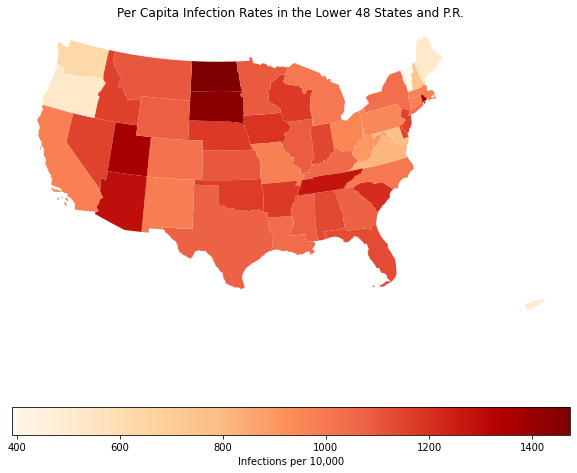

In [141]:
f, ax = plt.subplots(figsize = (10,10))
lower48_boundaries.plot(ax = ax, column = 'total_infections_per_capita',
                       cmap = 'OrRd',
                       legend = True, legend_kwds = {
                          'orientation': 'horizontal',
                          'label': 'Infections per 10,000'     
                      })
ax.set_axis_off()
ax.set_title("Per Capita Infection Rates in the Lower 48 States and P.R.")
plt.show()

Recently, there have been a few articles in the NYT that talked about the divergence in vaccinations rates in the US. Can we see the effect of this borne out in the case numbers?   

In [142]:
state_moving_average = fidap.sql("""
WITH covid_cases AS (
SELECT *, 
ROW_NUMBER() OVER (PARTITION BY state_name ORDER BY date ASC) AS row_num,
(confirmed_cases - (LAG(confirmed_cases, 1) OVER (PARTITION BY state_name ORDER BY date ASC))) AS new_cases,
(deaths - (LAG(deaths, 1) OVER (PARTITION BY state_name ORDER BY date ASC))) AS new_deaths,
FROM bigquery-public-data.covid19_nyt.us_states
WHERE date >= CAST('2021-05-31' AS DATE)
AND confirmed_cases >= 0 
AND deaths >= 0), 

acs_join AS (
SELECT CAST(c.date AS STRING) AS nyt_date, c.state_name, c.confirmed_cases, c.deaths, c.new_cases, c.new_deaths, c.row_num,
ROUND(10000*(AVG(c.new_cases) OVER (PARTITION BY c.state_name ORDER BY c.date ASC ROWS 7 PRECEDING))/acs.total_pop, 2) AS new_cases_ma7,
ROUND(10000*(AVG(c.new_deaths) OVER (PARTITION BY c.state_name ORDER BY c.date ASC ROWS 7 PRECEDING))/acs.total_pop, 2) AS new_deaths_ma7,
FROM covid_cases AS c
INNER JOIN bigquery-public-data.census_bureau_acs.state_2018_5yr AS acs 
ON acs.geo_id = c.state_fips_code),

final_query AS (
SELECT nyt_date, state_name, confirmed_cases, deaths, new_cases, new_deaths, 
IF(row_num < 7, NULL, new_cases_ma7) new_cases_ma7,
IF(row_num < 7, NULL, new_deaths_ma7) new_deaths_ma7
FROM acs_join)

SELECT *, 
CASE WHEN state_name IN ("Maine", "New Hampshire", "Vermont", "Massachusetts", "Rhode Island", "Connecticut", "New York", "New Jersey", "Pennsylvania") THEN 'Northeast'
    WHEN state_name IN ('Ohio', 'Michigan', 'Indiana', 'Wisconsin', 'Illinois', 'Minnesota', 'Iowa', 'Missouri', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas') THEN 'Midwest'
    WHEN state_name IN ('Montana', 'Idaho', 'Wyoming', 'Colorado', 'New Mexico', 'Arizona', 'Utah', 'Nevada', 'California', 'Oregon', 'Washington', 'Alaska', 'Hawaii') THEN 'West'
    ELSE 'South' END AS region
FROM final_query
WHERE new_deaths_ma7 IS NOT NULL
AND state_name <> "Florida";
""")

In [143]:
# convert to date time
state_moving_average['nyt_date'] = pd.to_datetime(state_moving_average['nyt_date'], format = '%Y-%m-%d')
state_moving_average['nyt_date'] = state_moving_average['nyt_date'].dt.normalize()

We see that grouping them by states makes it difficult to visualize because there are 50 states. Perhaps we should group them by regions. Even so, we see it is quite clear that there are some states with elevated case and body counts.

In [144]:
alt.Chart(state_moving_average).mark_line().encode(
    x = 'nyt_date',
    y = 'new_cases_ma7',
    color = 'state_name'
)

alt.Chart(...)

We can group them following the US Census Bureau's Statistical Region classification but add a tooltip so people can still know which state they are mousing over.

In [145]:
alt.Chart(
    state_moving_average,
    title = "7-Day Moving Average of New Cases").mark_line(
    opacity = 0.5).encode(
    x = 'nyt_date',
    y = 'new_cases_ma7',
    color = 'region',
    detail = 'state_name',
    tooltip = ['region', 'state_name', 'new_cases_ma7', 'new_deaths_ma7']
).interactive()

alt.Chart(...)

Interestingly, cases seem to be on the rise in the West and South. 